# AMSC698K Homework 8
##### Elijah Kin & Noorain Noorani

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo

In [2]:
# Load in stocks from .csv files
stocks = ["AAL", "AAPL", "AMD", "AMZN", "BAC", "BBBY", "BP", "CITI", "GE", "GOOG", "IBM", "INTC", "MSFT"]
startdate = "2015-01-01"
enddate = "2015-12-31"

dflist = [pd.read_csv(f"stocks/{name}.csv", usecols=["Date", "Close"], parse_dates=["Date"], index_col=["Date"]) for name in stocks]
dfStocks = pd.concat(dflist, axis=1, keys=stocks, names=["Stock", "Price"])
del dflist
dfStocks = dfStocks.swaplevel("Stock", "Price", axis=1).Close

display(dfStocks.describe())

stock_data = dfStocks.loc[startdate:enddate]

Stock,AAL,AAPL,AMD,AMZN,BAC,BBBY,BP,CITI,GE,GOOG,IBM,INTC,MSFT
count,3659.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,5100.000000,3938.000000,5100.000000,5100.000000,5100.000000
mean,27.042170,62.624447,12.968423,382.391033,26.694560,39.792375,48.039762,219.159160,27.084415,503.993794,129.525888,29.766260,43.913794
std,16.729262,69.748188,10.448804,545.880081,13.186198,16.943188,11.133204,201.674457,10.820207,354.511788,38.202097,12.024086,31.233204
min,1.760000,0.937143,1.620000,5.970000,3.140000,3.560000,16.110001,10.200000,6.110000,49.681866,55.070000,12.080000,15.150000
25%,9.615000,5.072500,4.890000,40.912498,15.317500,28.945001,40.184999,47.495000,18.600000,236.998558,94.449997,21.250000,26.580000
50%,29.709999,30.184286,9.495000,124.860001,25.836875,38.155001,45.120001,70.435001,27.085000,327.385666,125.265000,26.025000,29.855001
75%,41.609999,101.935001,17.394999,393.432495,36.871249,48.242501,54.131251,457.500000,34.000000,739.655014,159.005001,34.529999,46.759998
max,62.950001,327.200012,58.900002,2170.219971,54.900002,80.480003,79.699997,588.750000,60.000000,1526.689941,215.800003,74.875000,188.699997


In [3]:
def plot_stock_prices(data, names=["all"], format="raw", ax=None):
    if len(names)==0 or names[0].upper() == "ALL":
        if isinstance(data, pd.DataFrame):
            names = data.columns.tolist()
        else:
            names = stocks
    formatkey = {"norm":"Normalized", "raw":"Raw", "eq":"Equalized"}
    if format not in list(formatkey.keys())+list(formatkey.values()):
        print(f"Unknown format '{format}' (valid are {list(formatkey.keys())})")
        return
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    for j, name in enumerate(names):
        if isinstance(data, pd.DataFrame):
            if name not in data.columns:
                continue
            mydata = data[name].to_numpy()
        elif data._data:             # qiskit_finance.data_providers
            mydata = np.array(data._data[j])
        if format.lower() == "raw":
             ax.plot(mydata, label=name)
        elif format.lower().startswith("eq"):
            ax.plot(mydata/mydata[0], label=name)
        elif format.lower().startswith("norm"):
            minvalue, maxvalue = np.min(mydata), np.max(mydata)
            if maxvalue - minvalue < 1e-3:
                ax.plot((mydata - minvalue), label=name)
            else:
                ax.plot((mydata - minvalue)/(maxvalue - minvalue), label=name)

    ax.set_title(f"{formatkey[format]} Yearly Evolution of Stock Prices")
    ax.legend(bbox_to_anchor=(1.0,1.0))
    plt.xticks(rotation=30)
    plt.show()

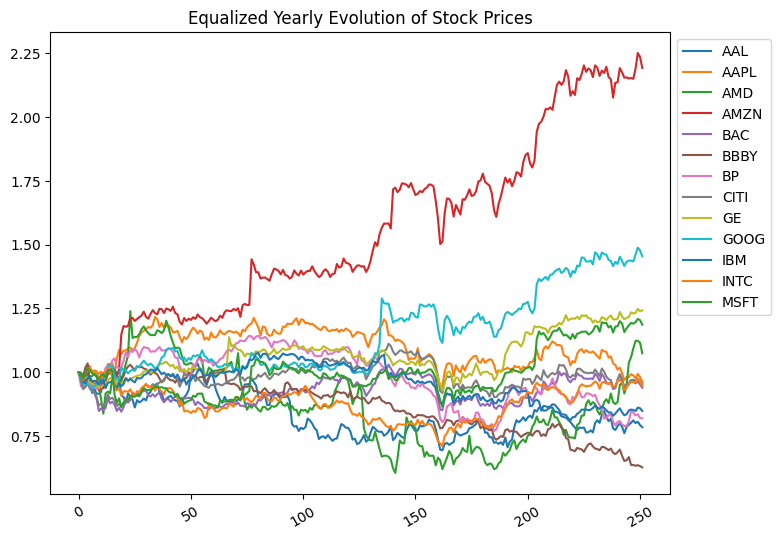

In [4]:
plot_stock_prices(stock_data, format='eq')

### Problem 1
Portfolio optimization is being considered as one of the early applications of quantum computing. You may use data providers or the csv files on the [google drive](https://drive.google.com/drive/u/1/folders/1PTjiX00a446ZF_44bceq7Lrmn1tST7rh). Choose historical data for 12 stocks for the years 2015, 2017, 2019 and find the 4 stocks with best equalized returns (i.e. relative to their initial value). For each part of the problem compare these 3 optimization methods: (a) a classical minimizer, (b) VQE, (c) QAOA.

### Creating the Quadratic Program

In [15]:
def get_returns_mean(data):
    return data.pct_change(1).mean().to_numpy()

def get_returns_covariance(data):
    return data.pct_change(1).cov().to_numpy()

# Create the quadratic program
portfolio = PortfolioOptimization(expected_returns=get_returns_mean(stock_data),
                                  covariances=get_returns_covariance(stock_data),
                                  risk_factor=0.2, budget=4)

qp = portfolio.to_quadratic_program()
print(qp.prettyprint())

Problem name: Portfolio optimization

Minimize
  0.00011066493668599907*x_0^2 + 4.8888898836831465e-05*x_0*x_1
  + 3.762757194223175e-05*x_0*x_10 + 5.190512077796261e-05*x_0*x_11
  + 5.97396580454786e-05*x_0*x_12 + 3.5721332548582474e-05*x_0*x_2
  + 3.91741304874832e-05*x_0*x_3 + 4.4964729043702285e-05*x_0*x_4
  + 4.81470182008187e-05*x_0*x_5 + 2.302693315478891e-05*x_0*x_6
  + 5.2133388169552955e-05*x_0*x_7 + 2.753815586673624e-05*x_0*x_8
  + 5.361728438258088e-05*x_0*x_9 + 5.6877592469067755e-05*x_1^2
  + 4.670816079950685e-05*x_1*x_10 + 4.571829510857314e-05*x_1*x_11
  + 6.294079246406207e-05*x_1*x_12 + 4.15823140111389e-05*x_1*x_2
  + 5.182621001001661e-05*x_1*x_3 + 5.228339935105061e-05*x_1*x_4
  + 3.809535567669835e-05*x_1*x_5 + 3.97098568746474e-05*x_1*x_6
  + 5.3131658745571116e-05*x_1*x_7 + 3.8045431736866377e-05*x_1*x_8
  + 4.77979320496279e-05*x_1*x_9 + 3.59869325591254e-05*x_10^2
  + 4.3904016544052266e-05*x_10*x_11 + 5.261970353217311e-05*x_10*x_12
  + 4.774555140628068e-0

### Solving via Classical Minimizer

In [16]:
# display the result of VQE or Classical EigenSolver
def display_values(vqe_result, stocks):
    lines = []
    for result in vqe_result.samples[:5]:
        qubits, value, probability = result.x, result.fval, result.probability
        q_str = str(qubits.astype(int)).ljust(16)
        arr = np.array(qubits)
        opt = [str(stock[0])+' ' for stock in np.take(stocks, np.argwhere(arr))]
        opt_str = "".join(opt).ljust(16)
        lines.append((opt_str, f'{q_str} {opt_str} {round(value, 4)} \t {round(probability, 4)}'))
    print(f'        Optimal Stock Combination: {lines[0][0]}')
    print('qubits \t\t selection \t value \t\t probability')
    [ print(p[1]) for p in lines ]
    print('-' * 60, '\n')

def plot_portfolio_against_market(result, stock_prices, budget=4):
    portfolio_select = np.argwhere(result.samples[0].x).reshape(-1)
    fig, ax = plt.subplots(figsize=(8, 6))
    if isinstance(stock_prices, pd.DataFrame):
        stocks = list(stock_prices.columns)
    else:
        stocks = stock_prices._tickers
    portfolio_sum = []
    for (cnt, st) in enumerate(stocks):
        if isinstance(stock_prices, pd.DataFrame):
            eq = stock_prices[st]/stock_prices[st].iloc[0]
        elif stock_prices._data:
            eq = np.array(stock_prices._data[cnt]) / stock_prices._data[cnt][0]
        if cnt in portfolio_select:
            portfolio_sum.append(eq)
            ax.plot(eq, label=f"{st} (Selected)", linestyle="--", alpha=0.5)
        else:
            ax.plot(eq, label=st, alpha=0.15)
    sab = sum(portfolio_sum)
    ax.plot(sab / budget, label="Portfolio Value")
    ax.set_title("Portfolio Performance")
    ax.legend()
    plt.show()


In [38]:
def solve_classical(qp):
  exact_mes = NumPyMinimumEigensolver()
  exact_eigensolver = MinimumEigenOptimizer(exact_mes)

  result_class = exact_eigensolver.solve(qp)

  display_values(result_class, stocks)
  plot_portfolio_against_market(result_class, stock_data)

        Optimal Stock Combination: AMZN GE GOOG MSFT 
qubits 		 selection 	 value 		 probability
[0 0 0 1 0 0 0 0 1 1 0 0 1] AMZN GE GOOG MSFT  -0.0062 	 1.0
------------------------------------------------------------ 



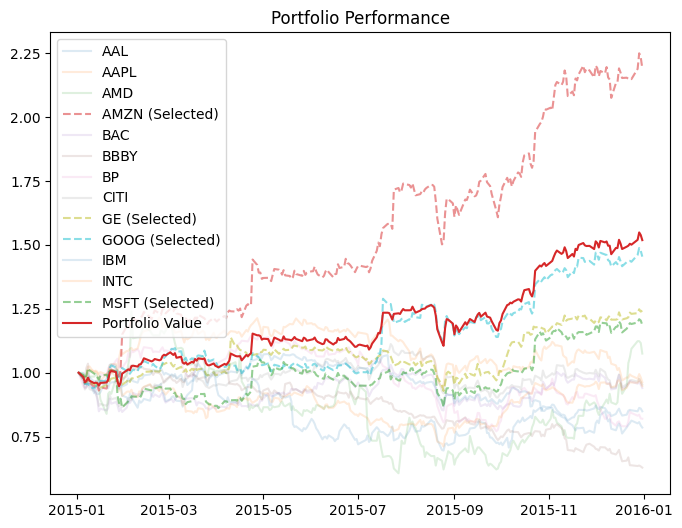

In [39]:
solve_classical(qp)

### Solving via VQE

In [ ]:
def solve_vqe(qp):
  qp_ising = QuadraticProgramToQubo().convert(qp)

  ansatz = RealAmplitudes(num_qubits=qp.get_num_binary_vars(), reps=3, entanglement='full')
  optimizer = COBYLA(maxiter=30)

  alpha = 0.5 # confidence level (optional)
  method = SamplingVQE(sampler=Sampler(), ansatz=ansatz, optimizer=optimizer, aggregation=alpha)
  optim = MinimumEigenOptimizer(method)
  result_vqe1 = optim.solve(qp_ising)

  display_values(result_vqe1, stocks)
  plot_portfolio_against_market(result_vqe1, stock_data)

        Optimal Stock Combination: AMD AMZN GOOG MSFT 
qubits 		 selection 	 value 		 probability
[0 0 1 1 0 0 0 0 0 1 0 0 1] AMD AMZN GOOG MSFT  -0.0059 	 0.001
[0 0 0 1 0 0 0 0 1 1 0 1 0] AMZN GE GOOG INTC  -0.0054 	 0.002
[0 0 1 1 0 0 0 0 1 0 0 0 1] AMD AMZN GE MSFT  -0.0053 	 0.002
[0 0 1 1 0 0 0 0 0 1 0 1 0] AMD AMZN GOOG INTC  -0.005 	 0.002
[0 0 0 1 0 0 0 0 0 1 1 0 1] AMZN GOOG IBM MSFT  -0.0046 	 0.001
------------------------------------------------------------ 



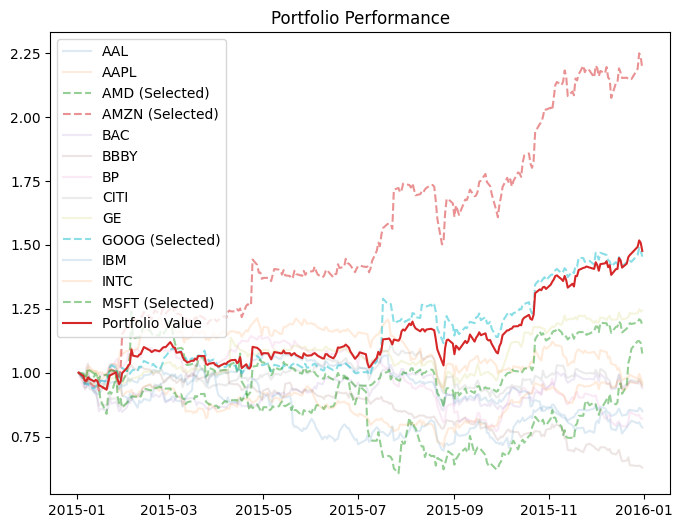

In [52]:
solve_vqe(qp)

### Solving via QAOA

In [45]:
def solve_qaoa(qp, layers=3):
  optimizer = COBYLA(maxiter=50)

  method = QAOA(sampler=Sampler(), optimizer=optimizer, reps=layers)
  optim = MinimumEigenOptimizer(method)
  result_qaoa = optim.solve(qp)

  display_values(result_qaoa, stocks)
  plot_portfolio_against_market(result_qaoa, stock_data)

        Optimal Stock Combination: AMZN GE GOOG MSFT 
qubits 		 selection 	 value 		 probability
[0 0 0 1 0 0 0 0 1 1 0 0 1] AMZN GE GOOG MSFT  -0.0062 	 0.001
[0 0 1 1 0 0 0 0 1 1 0 0 0] AMD AMZN GE GOOG  -0.0061 	 0.002
[0 1 0 1 0 0 0 0 1 1 0 0 0] AAPL AMZN GE GOOG  -0.0054 	 0.002
[0 1 0 1 0 0 0 0 0 1 0 0 1] AAPL AMZN GOOG MSFT  -0.0051 	 0.001
[0 1 1 1 0 0 0 0 0 1 0 0 0] AAPL AMD AMZN GOOG  -0.0051 	 0.002
------------------------------------------------------------ 



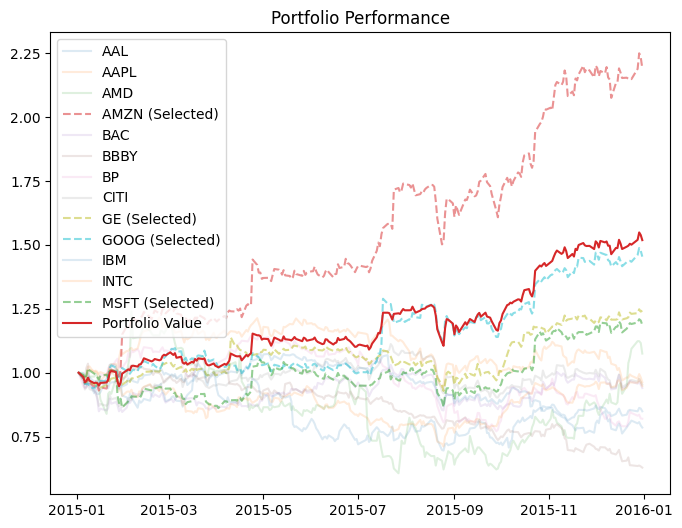

In [46]:
solve_qaoa(qp, layers=4)

1.A) Analyze the portfolio and compare to market (stocks that were not selected) using the historical data of all 3 years together;

In [ ]:
# TODO

1.B) Analyze the portfolio and compare to market when optimizing the portfolio for each year separately.

In [8]:
# TODO

### Problem 2
For this study you may choose the same 12 stocks or random data for 12 datasets over 1 year.

2.A) Compare the outcome and convergence speed using VQE for 4 variational forms:

1. 2 sets of rotation and entanglement blocks using only parametrized Ry-gates for each qubit in each rotation block and CX-gates in linear arrangement (CX(qi,qj) for all j=i+1) for entanglement.
2. 4 sets of rotation and entanglement layers using only parametrized Ry-gates for each qubit in each rotation block and CX-gates in linear arrangement for entanglement.
3. 2 sets of rotation and entanglement layers using parametrized Ry-gates and Rz-gates for each qubit in each rotation block and CX-gates in full arrangement (CX(qi,qj) for all combination of i,j) for entanglement.
4. 4 sets of rotation and entanglement layers using parametrized Ry-gates ad Rz-gates for each qubit in each rotation block and CX-gates in full arrangement for entanglement.

In [9]:
# TODO

2.B) Compare outcome and convergence speed of part 2.A with an optimization using QAOA with 2 and 4 layers.

In [10]:
# TODO